In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from dotenv import  load_dotenv

import numpy as np
sys.path.append('../../system/')
from get_similarity.utils.preprocess import preprocess
# from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore
from langchain_chroma import Chroma
from configs import JD_PATH, COLLECTION, DB_PATH
from langchain_community.retrievers import BM25Retriever
import string
from langchain.text_splitter import RecursiveCharacterTextSplitter

from insert_chunks import *
from tqdm import tqdm
from collections import defaultdict
import re
from uuid import uuid4

## 현재 vectorDB query process

In [3]:
# 생성된 CV전문(`generated_cv`column)을 Omniparser로 처리된 데이터로 가정
# o3-mini의 generation_score가 제일높아 사용
dataset = pd.read_csv("./data/evaluation/o3-mini_evaluation_large.csv")
print(f"벤치마크 데이터셋 크기: {len(dataset)}")

벤치마크 데이터셋 크기: 300


In [5]:
dataset.head()

,id,cv_example,jd,generated_cv,skill_score,experience_score,culture_fit_score,readability_score,generation_score,reasoning
0,0,"TECHNICAL SKILLS • HP ALM, RTC and JIRA • AS40...","Full Stack Developer, Senior**The Opportunity:...","TECHNICAL SKILLS • Languages: Java, Python, Ja...",90,85,80,85,90,The resume demonstrates a strong match with th...
1,1,KEY SKILLS: • Planning & Strategizing • Presen...,Full\\-Stack Web Developer**The Opportunity:**...,KEY SKILLS: • Full‐Stack Development • UI/UX C...,90,90,85,80,85,The resume demonstrates a strong alignment wit...
3,3,Education Details \r\nJanuary 2016 BSc. Mumba...,Posted Date\n\n\n5/08/2025\n\n\nDescription\n\...,Education Details \nJanuary 2014 BSc. Computer...,90,90,85,90,85,Skills Score: The resume lists the required ba...
4,4,SKILLS • 1.Autocad • 2.Pro v • 3.Catia • 4.wor...,Posted Date\n\n\n5/07/2025\n\n\nDescription\n\...,SKILLS • 1.Java • 2.Python • 3.Node.js • 4.SQL...,90,85,90,75,80,Skills: The candidate demonstrates proficiency...
5,5,Computer Skills: • Proficient in MS office (Wo...,"**About Us**\n At Hayden AI, we are on a missi...","Computer Skills: • Proficient in AWS CLI, Clou...",90,90,80,85,85,The resume clearly highlights essential techni...


In [6]:
dataset = dataset[dataset["generation_score"]>=40]
print(f"필터링된 데이터셋 크기: {len(dataset)}")

jd = dataset['jd']
generated_cv = dataset['generated_cv']

필터링된 데이터셋 크기: 179


In [7]:
# 현재 JobPT의 쿼리 전처리

def preprocess_query(parsed_content):

    lines = parsed_content.split("\n")

    texts = []
    for line in lines:
        if ":" in line:
            text = line.split(":", 1)[1].strip()
            texts.append(text)

    processed_texts = []
    i = 0
    while i < len(texts):
        text = texts[i]
        if text.endswith("-"):
            text = text[:-1]
            if i + 1 < len(texts):
                text += texts[i + 1]
                i += 1
        processed_texts.append(text)
        i += 1

    combined_text = " ".join(processed_texts)

    sentence_endings = re.compile(r"(?<=[.!?]) +")
    sentences = sentence_endings.split(combined_text)

    paragraphs = []
    current_paragraph = ""
    for sentence in sentences:
        headings = ["Education", "Publications", "Honors", "Relevant Courses", "GPA", "Advisor", "Minor", "Email", "Research Advisor"]
        if any(heading in sentence for heading in headings):
            print(f"sentence: {sentence}")
            if current_paragraph:
                paragraphs.append(current_paragraph.strip())
            current_paragraph = sentence.strip() + " "
        else:
            current_paragraph += sentence.strip() + " "

    if current_paragraph:
        paragraphs.append(current_paragraph.strip())

    # for para in paragraphs:
        # print(para)
        # print("\n")

    return "\n".join(paragraphs)

In [8]:
print(preprocess_query(generated_cv[0]))

Java, Python, JavaScript, C# • Frameworks: Spring Boot, Node.js, React, Angular • Tools: Git, Docker, Kubernetes, Jenkins, Maven, Gradle • Cloud: AWS, Azure • Database: SQL, NoSQL (MongoDB) • Others: API Design, Microservices, Agile & Scrum


# Benchmark  
- chunking: semantic
- preprocess: true

In [15]:
queries = generated_cv
# answers = jd

In [16]:
def get_chunks_bench(df, text_splitter):
    ## 데이터 프레임을 넣으면 chunking된 결과를 리턴
    total_chunks = []
    for i, desciption in enumerate(tqdm(df)):
        ### 메타데이터는 각 jd별 index로 지정
        chunk = text_splitter.create_documents([desciption], [{"index": i}])
        total_chunks.extend(chunk)
    return total_chunks

In [17]:
total_chunks = get_chunks_bench(jd, set_splitter(emb_model))

100%|██████████| 179/179 [00:01<00:00, 115.26it/s]


In [ ]:
def make_test_db(total_chunks, emb_model):
    try:
        db.reset_collection()
    except NameError:
        pass
    db = Chroma.from_documents(total_chunks, emb_model, collection_name=str(uuid4()))
    print(f"생성된 DB의 크기: {len(db.get()['ids'])}")
    return db

생성된 DB의 크기: 721


In [19]:
db = make_test_db(total_chunks, emb_model)

생성된 DB의 크기: 721


In [20]:
# 쿼리 테스트
db.similarity_search("I want to be a Data Scientist.")

[Document(id='752a30d1-487c-46b7-a01f-2fb873e25a01', metadata={'index': 161}, page_content='Data Scientist**The Opportunity:**\n\nAs a data scientist, you’re excited at the prospect of unlocking the secrets held by a data set, and you’re fascinated by the possibilities presented by IoT, machine learning, and artificial intelligence. In an increasingly connected world, massive amounts of structured and unstructured data open new opportunities. As a data scientist at Booz Allen, you can help turn these complex data sets into useful information to solve global challenges. Across private and public sectors from fraud detection to cancer research, to national intelligence, we need you to help find the answers in the data. On our team, you’ll use your leadership skills and data science expertise to create real\\\\-world impact. You’ll work closely with clients to understand their questions and needs, and then dig into their data\\\\-rich environments to find the pieces of their information p

In [23]:
retriever = db.as_retriever(search_kwargs={"k": 3}, embedding_function=emb_model)  # top-3 문서 검색  # 임베딩 모델 명시적 지정

In [31]:
def make_rank(results,k, full=False):
    ## query와 db를 넣으면 id의 list를 리턴
    search_range = min(k, len(results))
    scores = np.full([search_range], -1)
    for i in range(search_range):
        scores[i] = results[i].metadata['index']
    return scores

In [29]:
retriever.invoke("I want to be a Data Scientist.")

[Document(id='752a30d1-487c-46b7-a01f-2fb873e25a01', metadata={'index': 161}, page_content='Data Scientist**The Opportunity:**\n\nAs a data scientist, you’re excited at the prospect of unlocking the secrets held by a data set, and you’re fascinated by the possibilities presented by IoT, machine learning, and artificial intelligence. In an increasingly connected world, massive amounts of structured and unstructured data open new opportunities. As a data scientist at Booz Allen, you can help turn these complex data sets into useful information to solve global challenges. Across private and public sectors from fraud detection to cancer research, to national intelligence, we need you to help find the answers in the data. On our team, you’ll use your leadership skills and data science expertise to create real\\\\-world impact. You’ll work closely with clients to understand their questions and needs, and then dig into their data\\\\-rich environments to find the pieces of their information p

In [32]:
make_rank(retriever.invoke("I want to be a Data Scientist."), k=10)

array([161, 161, 160])

In [34]:
def make_score(queries, db, full=False):
    ## query와 db를 넣으면 score(0: 오답, 1: 정답)를 리턴
    scores = np.zeros([len(queries), 10])
    for i in tqdm(range(len(queries))):
        query = queries.iloc[i]
        results = db.similarity_search(query, k=10)
        for j in range(len(results)):
            if results[j].metadata['index'] ==  i:
                scores[i][j] = 1
    return scores

In [35]:
scores = make_score(queries, db)

100%|██████████| 179/179 [01:15<00:00,  2.38it/s]


In [36]:
def print_score(scores):
    one_shot = scores[:,0]
    # 10개 중 하나라도 매칭된 이력서가 있다면 정답으로 취급
    ten_shot = np.sum(scores[:,:10], axis=1)

    one_shot = np.mean(one_shot)
    ten_shot = (ten_shot > 0).mean()

    print(f"1-shot accuracy: {one_shot*100:.2f}%")
    print(f"10-shot accuracy: {ten_shot*100:.2f}%")

In [37]:
print_score(scores)

1-shot accuracy: 78.21%
10-shot accuracy: 95.53%


## BM25 성능평가

In [38]:
def clean_tokens(text: str):
    """공백 기준 토큰화 후 특수문자 제거·소문자 변환"""
    tokens = text.split()                       # ① 공백 기준 분리
    cleaned = []
    for tok in tokens:
        # ② 토큰 앞뒤 특수문자 제거  ( ###Job**  →  Job )
        tok = tok.strip(string.punctuation)
        # ③ 소문자 변환
        tok = tok.lower()
        # ④ 빈 토큰·순수 특수문자 토큰은 건너뛰기
        if tok and not all(ch in string.punctuation for ch in tok):
            cleaned.append(tok)
    return cleaned

In [39]:
lexical_db = BM25Retriever.from_documents(total_chunks, preprocess_func=clean_tokens, k=10)

In [40]:
def make_lexical_score(queries, lexical_db, full=False):
    scores = np.zeros([len(queries), 10])
    for i in tqdm(range(len(queries))):
        query = queries.iloc[i]
        results = lexical_db.get_relevant_documents(query, k=10)
        for j in range(len(results)):
            if results[j].metadata['index'] ==  i:
                scores[i][j] = 1
    return scores

In [41]:
scores = make_lexical_score(queries, lexical_db)
print_score(scores)

  0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipykernel_38241/3035066337.py:5: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = lexical_db.get_relevant_documents(query, k=10)
100%|██████████| 179/179 [00:02<00:00, 62.55it/s]

1-shot accuracy: 61.45%
10-shot accuracy: 83.80%


### mekab 사용

In [ ]:
from nltk.tokenize import word_tokenize

lexical_db = BM25Retriever.from_documents(total_chunks, preprocess_func=word_tokenize)

In [44]:
scores = make_lexical_score(queries, lexical_db)
#분명 idf 리스트 체크할때는 더 clean해보였는데?
print_score(scores)

100%|██████████| 179/179 [00:03<00:00, 52.79it/s]

1-shot accuracy: 51.40%
10-shot accuracy: 74.86%


# JD청킹변경

In [46]:
def set_recursive_splitter(chunk_size=512, chunk_overlap=100):
    """splitter를 셋업하는 함수입니다."""
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap, separators=["#","##,""###","####","#####","---","**","*", "\r\n","\n\n", "\n", "\t", " ", ""])
    return text_splitter


In [47]:
recursive_splitter = set_recursive_splitter(chunk_size=1024, chunk_overlap=100)
recursive_chunks = get_chunks_bench(jd, recursive_splitter)
recursive_db = make_test_db(recursive_chunks, emb_model)
recursive_scores = make_score(queries, recursive_db, full=True)

100%|██████████| 179/179 [00:00<00:00, 13576.50it/s]


생성된 DB의 크기: 1366


100%|██████████| 179/179 [01:05<00:00,  2.71it/s]


In [48]:
print_score(recursive_scores)

1-shot accuracy: 71.51%
10-shot accuracy: 92.74%


In [94]:
print_score(scores)

1-shot accuracy: 72.07%
10-shot accuracy: 92.74%


In [49]:
lexical_db = BM25Retriever.from_documents(recursive_chunks, preprocess_func=word_tokenize, k=10,
                                          bm25_params={"k1": 1.2, "b": 0.5})
scores = make_lexical_score(queries, lexical_db, full=True)

100%|██████████| 179/179 [00:06<00:00, 27.29it/s]


In [50]:
print_score(scores)

1-shot accuracy: 51.96%
10-shot accuracy: 81.01%


# RRF

In [51]:
def make_rank(queries, db, full=False):
    ## query와 db를 넣으면 id의 list를 리턴
    scores = np.full([len(queries), 10], -1)
    for i in tqdm(range(len(queries))):
        query = queries.iloc[i]
        results = db.similarity_search(query, k=10)
        for j in range(len(results)):
            scores[i][j] = results[j].metadata['index']
    return scores

In [53]:
ranks = make_rank(queries, recursive_db, full=True)

100%|██████████| 179/179 [01:04<00:00,  2.79it/s]


In [54]:
def make_lexical_rank(queries, lexical_db, full=False):
    scores = np.full([len(queries), 10], -1)
    for i in tqdm(range(len(queries))):
        query = queries.iloc[i]
        results = lexical_db.invoke(query, k=10)
        for j in range(len(results)):
            scores[i][j] = results[j].metadata['index']
    return scores

In [55]:
# lexical_db = BM25Retriever.from_documents(total_chunks, preprocess_func=clean_tokens, k=10,
#                                            bm25_params={"k1": 1.2, "b": 0.5})
# lexical_db = BM25Retriever.from_documents(total_chunks, preprocess_func=clean_tokens, k=10)

lexical_ranks = make_lexical_rank(queries, lexical_db, full=True)

100%|██████████| 179/179 [00:06<00:00, 26.93it/s]


In [56]:
def rrf(multi_scores, k=1):        #n*10개의 입력, id로 들어옴
    score = 0.0
    score_dict = defaultdict(int)
    for scores in multi_scores:
        for rank, id in enumerate(scores):
            score = 1.0 / ( k + rank+1)       #index는 0부터 시작하므로 +1
            score_dict[id]+=score
    score_dict = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)
    return score_dict

In [ ]:
# RRF 성능 확인을 위해 각 점수를 chk'
semantic_scores = make_score(queries, db, full=True)
lexical_score = make_lexical_score(queries, lexical_db, full=True)

100%|██████████| 179/179 [00:06<00:00, 26.88it/s]


In [ ]:
print_score(semantic_scores)
print_score(lexical_score)

1-shot accuracy: 78.21%
10-shot accuracy: 95.53%
1-shot accuracy: 51.96%
10-shot accuracy: 81.01%


In [81]:
results=[]
for i,v in enumerate(range(len(queries))):
    result = rrf([ranks[i], lexical_ranks[i]], k=1)
    results.append(result)

In [82]:
scores = np.zeros([len(queries), 10])
for i in range(len(results)):
    for j in range(min(10, len(results[i]))):
        if results[i][j][0] == i:
            scores[i][j]=1

In [83]:
print_score(scores)

1-shot accuracy: 69.27%
10-shot accuracy: 95.53%


In [84]:
ranks = make_rank(queries, recursive_db, full=True)
lexical_db = BM25Retriever.from_documents(recursive_chunks, preprocess_func=clean_tokens, k=10)
lexical_ranks = make_lexical_rank(queries, lexical_db, full=True)

results=[]
for i,v in enumerate(range(len(queries))):
    result = rrf([ranks[i], lexical_ranks[i]], k=1)
    results.append(result)

scores = np.zeros([len(queries), 10])
for i in range(len(results)):
    for j in range(min(10, len(results[i]))):
        if results[i][j][0] == i:
            scores[i][j]=1

print_score(scores)

100%|██████████| 179/179 [00:07<00:00, 23.61it/s]

1-shot accuracy: 74.30%
10-shot accuracy: 95.53%


In [85]:
scores = np.zeros([len(queries), 10])
for i in range(len(results)):
    for j in range(min(10, len(results[i]))):
        if results[i][j][0] == i:
            scores[i][j]=1

print_score(scores)

1-shot accuracy: 74.30%
10-shot accuracy: 95.53%


In [ ]:
semantic_match = [i for i, num in enumerate(semantic_scores[:,0]) if num==1]
lexical_match = [i for i, num in enumerate(lexical_score[:,0]) if num==1]

# one shot 결과 확인하여 서로 보완이 가능할지 chk`
print(semantic_match)
print(lexical_match)

[2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 106, 107, 110, 111, 114, 115, 118, 120, 121, 122, 123, 124, 125, 127, 128, 129, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 150, 151, 152, 153, 154, 155, 156, 157, 160, 161, 162, 163, 164, 165, 169, 170, 171, 172, 174, 177, 178]
[6, 7, 9, 11, 15, 18, 22, 24, 25, 29, 31, 32, 41, 44, 48, 49, 50, 51, 52, 53, 55, 57, 58, 60, 61, 62, 63, 66, 69, 70, 71, 72, 76, 78, 79, 80, 81, 84, 85, 86, 87, 88, 92, 93, 95, 99, 100, 103, 106, 116, 117, 118, 121, 122, 124, 127, 128, 129, 130, 132, 133, 134, 135, 138, 139, 140, 141, 142, 144, 145, 146, 148, 150, 151, 152, 153, 154, 155, 156, 157, 159, 162, 164, 168, 169, 170, 171, 

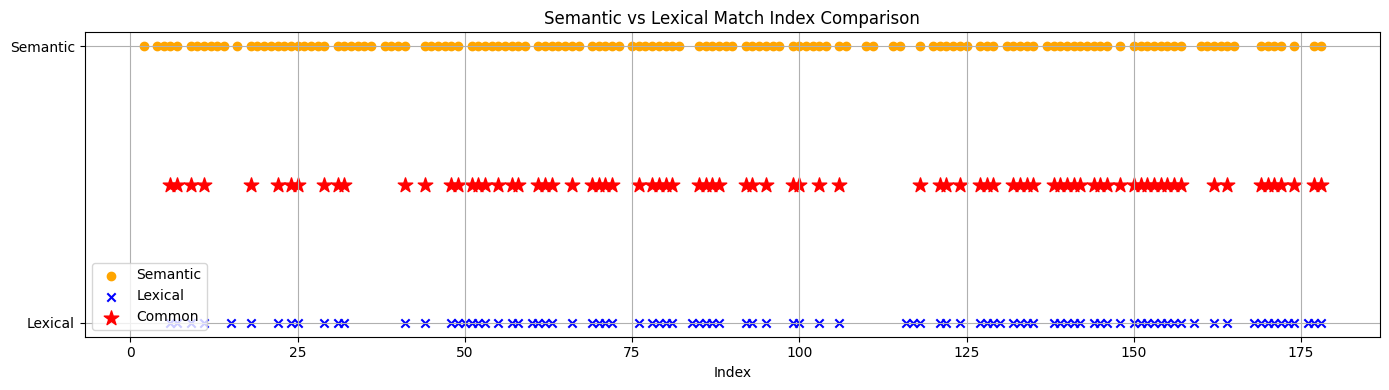

In [104]:
# 시각화
semantic_set = set(semantic_match)
lexical_set = set(lexical_match)
common = semantic_set & lexical_set

# 시각화
plt.figure(figsize=(14, 4))

# Semantic match
plt.scatter(semantic_match, [1]*len(semantic_match), label="Semantic", color="orange", marker="o")

# Lexical match
plt.scatter(lexical_match, [0]*len(lexical_match), label="Lexical", color="blue", marker="x")

# 공통 인덱스
plt.scatter(list(common), [0.5]*len(common), label="Common", color="red", marker="*", s=120)

plt.yticks([0, 1], ['Lexical', 'Semantic'])
plt.xlabel("Index")
plt.title("Semantic vs Lexical Match Index Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

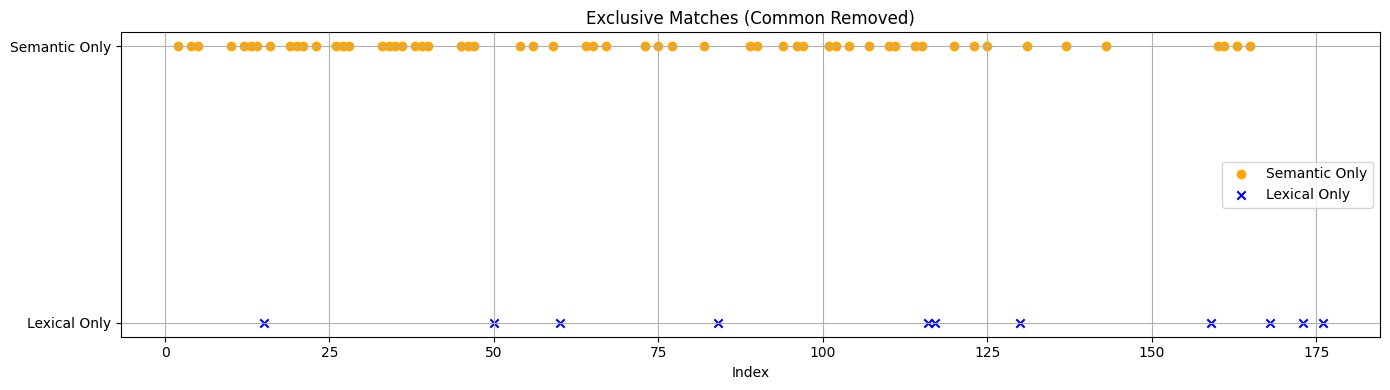

In [106]:
semantic_only = list(set(semantic_match) - set(lexical_match))
lexical_only = list(set(lexical_match) - set(semantic_match))

# 시각화
plt.figure(figsize=(14, 4))

# 고유 Semantic match (공통 제외)
plt.scatter(semantic_only, [1]*len(semantic_only), label="Semantic Only", color="orange", marker="o")

# 고유 Lexical match (공통 제외)
plt.scatter(lexical_only, [0]*len(lexical_only), label="Lexical Only", color="blue", marker="x")

# 레이블 및 레이아웃
plt.yticks([0, 1], ['Lexical Only', 'Semantic Only'])
plt.xlabel("Index")
plt.title("Exclusive Matches (Common Removed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()